### First set number of cores on machine to use and SSID number to analyse, then run all

In [1]:
# setting variables

cores = 3 # enter the number of cores to use here, in place of x
SSIDno = 44561284 # enter the SSID number to model as an int here, in place of xxxxxxxx
iters = 38 # enter the number of randomised search iterations here 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.font_manager as fm
import matplotlib
import autotime
%matplotlib inline
%load_ext autotime
#import seaborn as sns
import statsmodels as stm
import statsmodels.formula.api as sm

from sklearn import metrics
from sklearn.linear_model import LinearRegression as LinR

from sklearn.ensemble import GradientBoostingRegressor as GBR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV as RSCV

from sklearn.metrics.scorer import make_scorer
from scipy import stats
from scipy.stats import randint

#from sklearn.tree import export_graphviz
#from IPython.display import Image

## 1. Data processing stage

First, select route files to input based on SSIDno to analyse

### 1a Inputting data and creating dataframe for SSIDno

In [3]:
# Read in stop_times.txt and trips.txt files from NTA data
stop_times_2012 = pd.read_csv('stop_times.txt')
trips_2012 = pd.read_csv('trips.txt')

# Merge by trip_id
merge = pd.merge(stop_times_2012, trips_2012, on='trip_id', how='outer')

# Keep only necessary columns
merge.drop(['arrival_time','departure_time','pickup_type','drop_off_type','service_id','shape_dist_traveled'], axis=1, inplace=True)

# Transform trip_id to route and stop_id to StopID
merge['route_short'] = merge['trip_id'].apply(lambda x: x[x.index('-')+1:])
merge['route_short'] = merge['route_short'].apply(lambda x: x[: x.index('-')])
merge['route_short'] = merge['route_short'].apply(lambda x: str(x).zfill(4))
merge['StopID'] = merge['stop_id'].apply(lambda x: x[-4:])

# Find StopID and the sequence of that shape_id
gb = merge.groupby(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'])
gbc = gb.count()
gbc.reset_index(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'], inplace=True)
transit_shapeID_stopID = gbc.drop(['trip_id','stop_id','route_id','trip_headsign'], axis=1)

# create list of pairs of routes and the SSIDs contained within them
ssid = []
for i in range(len(transit_shapeID_stopID.index)-1):
    temp = transit_shapeID_stopID['StopID'].iloc[i] + transit_shapeID_stopID['StopID'].iloc[i+1]
    ssid.append([ transit_shapeID_stopID['route_short'].iloc[i],temp])
    
SSIDnoStr = str(SSIDno).zfill(8)
routes = [x for x in ssid if SSIDnoStr in x[1]]
routes = [item[0] for item in routes]
routes = list(set(routes))

# Reading in the route CSV files for the required SSID

res = pd.read_csv('Route_XXXX_travel_time_csvs/Blank_Route_travel_time.csv')
route_list = routes
for r in route_list:
    df = pd.read_csv('Route_XXXX_travel_time_csvs/Route_%s_travel_time.csv' % r)
    res = pd.concat([df, res], axis=0) 

time: 8.21 s


In [4]:
# create dataframe for SSIDno

res['SSID'] = res['SSID'].astype('category')
ssid_df = res[res.SSID == SSIDno]
ssid_df.reset_index(inplace=True)
ssid_df = ssid_df.drop('index', axis=1)
ssid_df.shape

(15766, 12)

time: 210 ms


In [5]:
JPID_Count = ssid_df.JourneyPatternID.unique().shape[0]
Row_Count = ssid_df.shape[0]
print("There are", JPID_Count, "unique JPIDs traversing this segment, over the course of", Row_Count, "observations.")

There are 19 unique JPIDs traversing this segment, over the course of 15766 observations.
time: 4 ms


In [6]:
# add leading zeroes to JourneyPatternID

ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.astype('object')
ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.apply(lambda x: str(x).zfill(8))

time: 14 ms


### 1b Adding extra features and altering/dropping existing ones

In [7]:
# adding Xbuses feature - boolean feature indicating whether or not the JourneyPatternID represents an express (X) bus

ssid_df['XBuses'] = ssid_df[ssid_df["JourneyPatternID"].str.find("X") > 0].sum(axis=1) > 0
ssid_df["XBuses"].fillna(False, inplace=True)
ssid_df['XBuses'] = ssid_df['XBuses'].astype('int')

time: 15 ms


In [8]:
# adding JPID_length feature - represents the total number of stops traversed by this JourneyPatternID along its entire route

JPIDL = pd.read_csv('JPID_Length.csv')
JPIDL = JPIDL.drop('Unnamed: 0', axis=1)
ssid_df = pd.merge(left=ssid_df ,right=JPIDL, how='left', left_on='JourneyPatternID', right_on='JourneyPatternID')
ssid_df = ssid_df.dropna()
ssid_df.shape

(15766, 14)

time: 22 ms


In [9]:
# removing non-holiday-period weekends from SchoolHoliday feature to avoid multi-collinearity issues

ssid_df['SchoolHoliday'] = ssid_df['SchoolHoliday'].astype('int')
ssid_df['SchoolHoliday'] = np.where(ssid_df['TimeFrame'].isin(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)

time: 4 ms


In [10]:
# dropping unneeded columns

ssid_df = ssid_df.drop(['SourceStopID', 'DestStopID', 'VehicleJourneyID', 'JourneyPatternID', 'SSID'], axis=1)

# reordering remaining columns

ssid_df = ssid_df[['TravelTime', 'Rain', 'WindSpeed', 'JPID_length', 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]

time: 5 ms


In [11]:
# assigning appropriate datatypes where necessary

ssid_df['Day'] = ssid_df['Day'].astype('category')
ssid_df['HourFrame'] = ssid_df['HourFrame'].astype('category')
ssid_df['JPID_length'] = ssid_df['JPID_length'].astype('int')

time: 34 ms


In [12]:
# removing any constant features
# code from: https://stackoverflow.com/questions/20209600/panda-dataframe-remove-constant-column

ssid_df = ssid_df.loc[:,ssid_df.apply(pd.Series.nunique) != 1]

time: 11 ms


In [13]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,Day,HourFrame
0,37,0.000000,15.0,60,0,Tuesday,8
1,60,0.000000,17.5,60,0,Tuesday,11
2,39,0.000000,17.0,60,0,Tuesday,14
3,60,0.000000,15.5,60,0,Tuesday,16
4,41,0.000000,15.0,60,0,Tuesday,20
5,43,0.000000,16.0,60,0,Tuesday,22
6,20,0.000000,12.0,60,0,Tuesday,6
7,19,0.000000,12.0,60,0,Tuesday,6
8,40,0.000000,15.5,60,0,Tuesday,9
9,61,0.000000,17.5,60,0,Tuesday,12


time: 25 ms


## 1c. Dropping Outliers

#### Visualising range of travel-time data first

Histiogram of values (x-axis is number of seconds)

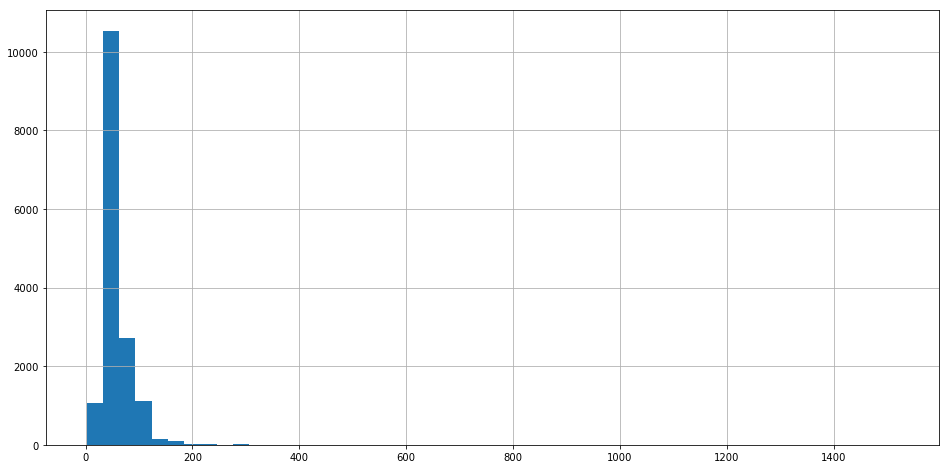

time: 243 ms


In [14]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

Boxplot to check for outliers

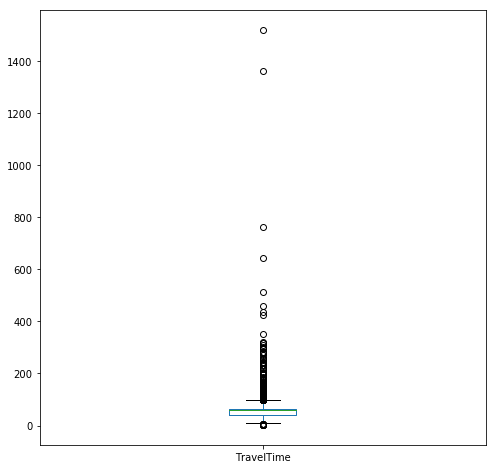

time: 215 ms


In [15]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

In [16]:
# Checking stats for TravelTime

ssid_df.TravelTime.describe()

count    15766.000000
mean        59.232589
std         32.606534
min          2.000000
25%         41.000000
50%         59.000000
75%         64.000000
max       1521.000000
Name: TravelTime, dtype: float64

time: 6 ms


Dropping outliers

In [17]:
# loading table of minimum times to traverse segments at 65kmph

find_lb = pd.read_csv('use_speed_and_distance_get_outlier_bound.csv')

# extracting value for this segment, to use as lower bound for outlier removal

lb = find_lb.loc[find_lb['SSID'] == SSIDno, 'min_sec'].iloc[0]
print(lb)

11.2607119134
time: 11 ms


In [18]:
# make a copy of original df

trimssid_df = ssid_df.copy()

# Remove TravelTime upper bound outliers beyond 3 x IQR, and lowerbound below 'lb'

ub = trimssid_df.quantile(q=.75) + (3*(trimssid_df.quantile(q=.75)-trimssid_df.quantile(q=.25)))
trimssid_df['OutlierTT'] = (trimssid_df['TravelTime'] < lb) | (trimssid_df['TravelTime'] > ub['TravelTime'])

# Outlier rows counted

Outlier_Count = trimssid_df[(trimssid_df['OutlierTT'] == True)].shape[0]
Row_Count = Row_Count - Outlier_Count

print("There will be", Outlier_Count, "outliers dropped.")

There will be 330 outliers dropped.
time: 20 ms


In [19]:
# dropping outliers

trimssid_df = trimssid_df[trimssid_df.OutlierTT != True]
trimssid_df.sort_values(['TravelTime'], ascending=False, inplace=True)
trimssid_df = trimssid_df.drop(['OutlierTT'], axis=1)
trimssid_df.reset_index(inplace=True)
trimssid_df = trimssid_df.drop('index', axis=1)

time: 41 ms


In [20]:
# Create TT mean/median value variables, to use in calculating mean/median absolute percentage accuracy scores
# and for horizontal lines in the charts below to represent the mean/medium

ssid_df = trimssid_df
ssid_df_mean = ssid_df.TravelTime.mean()
ssid_df_median  = ssid_df.TravelTime.median()
ssid_df.TravelTime.describe()

count    15436.000000
mean        56.796256
std         21.600658
min         13.000000
25%         40.000000
50%         59.000000
75%         62.000000
max        132.000000
Name: TravelTime, dtype: float64

time: 7 ms


#### Visualising range of data after dropping outliers

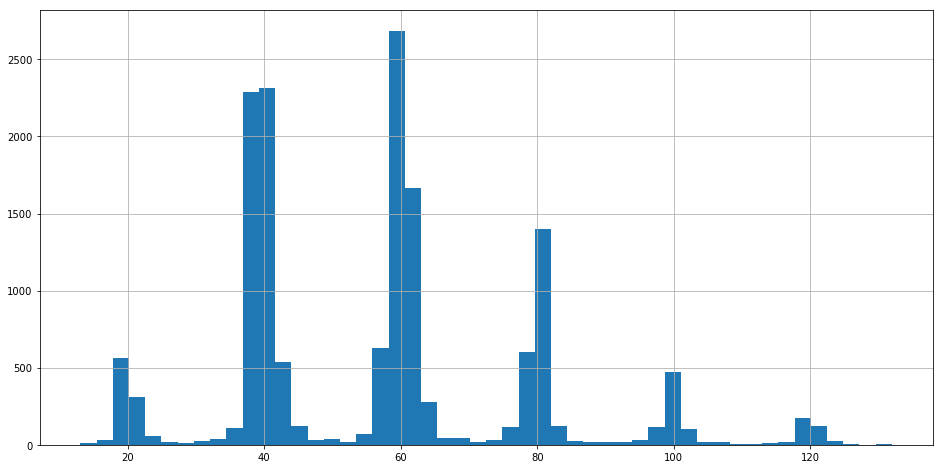

time: 206 ms


In [21]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

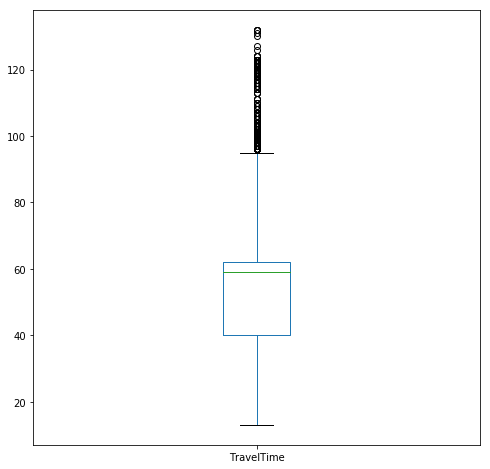

time: 193 ms


In [22]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

## 2. Visualising the data

### 2ai Bar plot for mean TravelTime per HourFrame

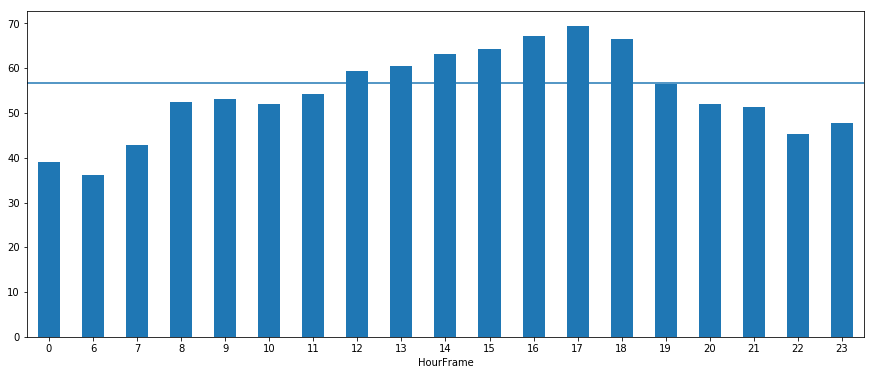

time: 189 ms


In [23]:
mean_HF = ssid_df.groupby('HourFrame')['TravelTime'].mean()
mean_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2aii Bar plot for median TravelTime per HourFrame

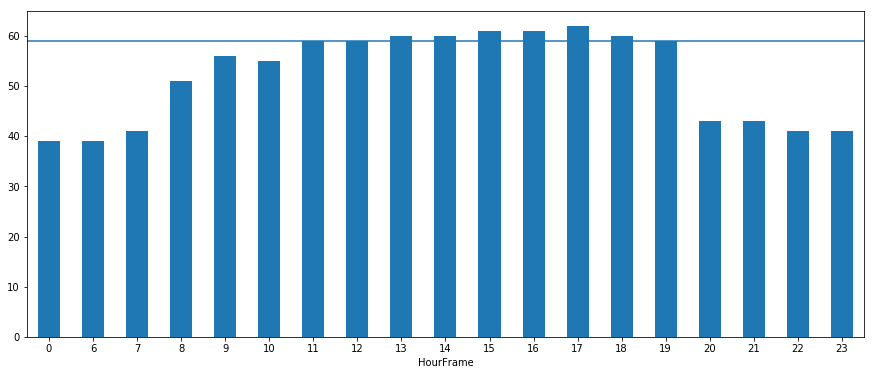

time: 187 ms


In [24]:
med_HF = ssid_df.groupby('HourFrame')['TravelTime'].median()
med_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bi Bar plot for mean TravelTime per Day

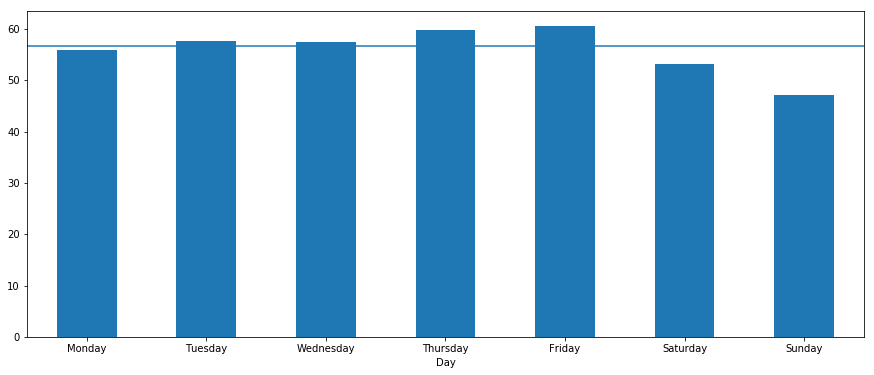

time: 144 ms


In [25]:
mean_Day = ssid_df.groupby('Day')['TravelTime'].mean()
mean_Day=mean_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

mean_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean

coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bii Bar plot for median TravelTime per HourFrame

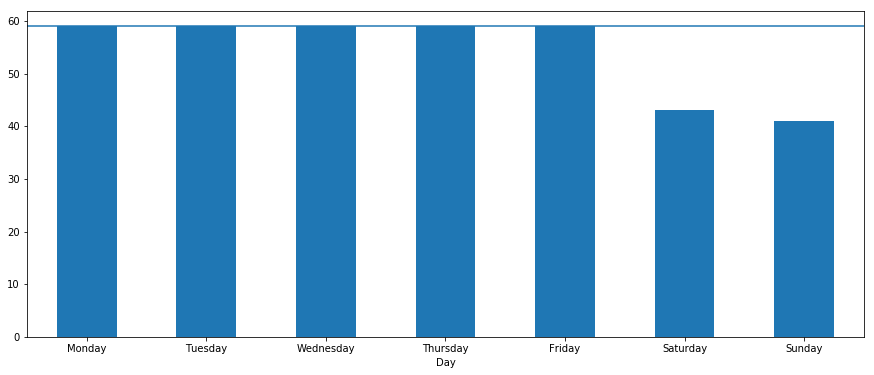

time: 143 ms


In [26]:
med_Day = ssid_df.groupby('Day')['TravelTime'].median()

med_Day=med_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
med_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation: 

### 2ci Bar plot for mean TravelTime when SchoolHoliday true/false

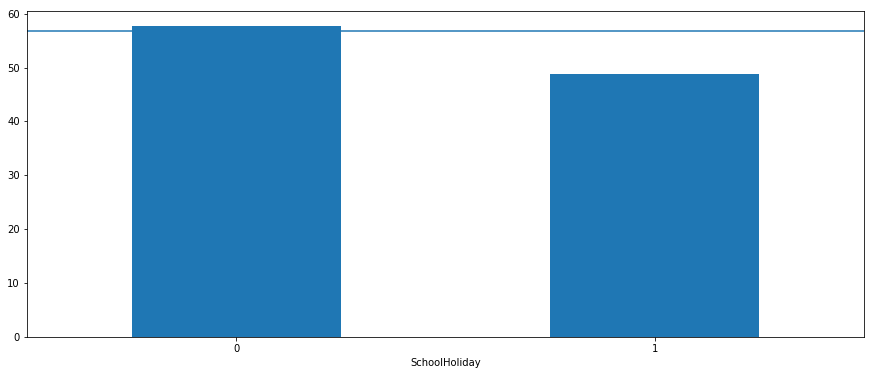

time: 163 ms


In [27]:
mean_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].mean()
mean_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2cii Bar plot for median TravelTime when SchoolHoliday true/false

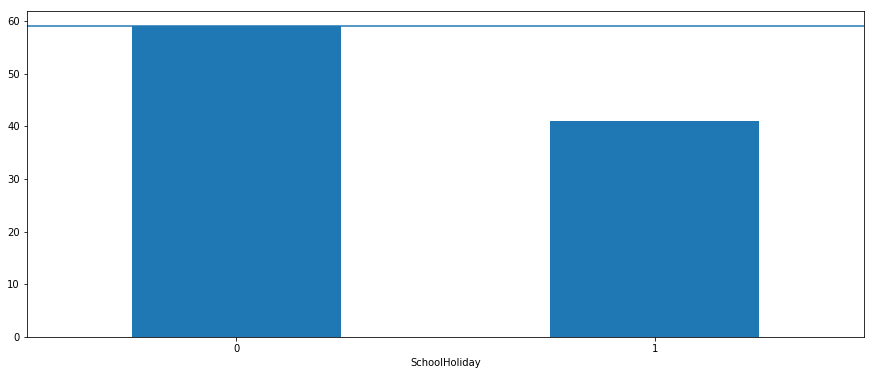

time: 127 ms


In [28]:
med_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].median()
med_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Splitting data into 70% for training and 30% for testing

## 3 Model training (Scikit-learn)

First we need to dreate dummy variables for categorical features, and split into test and training sets

### 3.1 Prepare data for modelling via Scikit-learn

In [29]:
# create dummy variables from HourFrame and Day using get_dummies
# dropping first values to avoid multicollinearity (Day = Friday, Hour = 0 or 6 or 7, depending on SSID)

Day_dummies = pd.get_dummies(ssid_df.Day, prefix='Day', drop_first=True)
HF_dummies = pd.get_dummies(ssid_df.HourFrame, prefix='HF', drop_first=True)

# concatenate the dummy variable columns onto the original DataFrame and drop the original features
ssid_df = pd.concat([ssid_df, HF_dummies, Day_dummies], axis=1)
ssid_df = ssid_df.drop(['HourFrame', 'Day'], axis=1)
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,HF_6,HF_7,HF_8,HF_9,HF_10,...,HF_20,HF_21,HF_22,HF_23,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,132,0.000000,16.5,76,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,132,2.300781,28.0,66,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,132,0.000000,7.0,53,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,132,2.099609,18.0,66,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,131,0.200000,11.5,76,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
5,130,0.000000,4.0,66,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,127,0.000000,12.0,76,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,126,0.000000,13.0,66,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,124,0.000000,5.0,66,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,124,0.033333,11.0,63,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


time: 54 ms


In [30]:
# prepare a list containing all remaining features bar the target
pred_features = list(ssid_df)
pred_features.remove('TravelTime')
print(pred_features)

['Rain', 'WindSpeed', 'JPID_length', 'SchoolHoliday', 'HF_6', 'HF_7', 'HF_8', 'HF_9', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18', 'HF_19', 'HF_20', 'HF_21', 'HF_22', 'HF_23', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
time: 1e+03 µs


In [31]:
# prepare target/predictive feature variables for use in scikit-learn modelling

X = ssid_df[pred_features]
y = ssid_df['TravelTime']

time: 3 ms


In [32]:
# split the data into training portion (70%) and final testing potion (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 38)

time: 5 ms


For comparison purposes, first train on Linear Regression

### 3.2a Linear Regression model (via scikit-learn) - training - default parameters

In [33]:
lr = LinR(n_jobs = cores)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

time: 13 ms


In [34]:

lr_pred = lr.predict(X_train)
lr_rsq = metrics.r2_score(y_train, lr_pred)
print ("The R-squared value of the Linear Regression model is", lr_rsq)
print()
lr_mae = metrics.mean_absolute_error(y_train, lr_pred)
print ("The mean absolute error of the Linear Regression model is", lr_mae)
print ("The mean absolute percentage error is", (((lr_mae)/ssid_df_mean)*100))
print()
lr_mdae = metrics.median_absolute_error(y_train, lr_pred)
print ("The median absolute error of the Linear Regression model is", lr_mdae)
print ("The median absolute percentage error is", (((lr_mdae)/ssid_df_median)*100))

The R-squared value of the Linear Regression model is 0.198201222366

The mean absolute error of the Linear Regression model is 14.9457437748
The mean absolute percentage error is 26.3146639537

The median absolute error of the Linear Regression model is 11.9118612889
The median absolute percentage error is 20.189595405
time: 10 ms


### 3.2b Linear Regression model (via scikit-learn) - testing - default parameters

In [35]:
lr_preda = lr.predict(X_test)
lr_rsqa = metrics.r2_score(y_test, lr_preda)
print ("The R-squared value of the Linear Regression model is", lr_rsqa)
print()
lr_maea = metrics.mean_absolute_error(y_test, lr_preda)
print ("The mean absolute error of the Linear Regression model is", lr_maea)
print ("The mean absolute percentage error is", (((lr_maea)/ssid_df_mean)*100))
print()
lr_mdaea = metrics.median_absolute_error(y_test, lr_preda)
print ("The median absolute error of the Linear Regression model is", lr_mdaea)
print ("The median absolute percentage error is", (((lr_mdaea)/ssid_df_median)*100))

The R-squared value of the Linear Regression model is 0.215102171414

The mean absolute error of the Linear Regression model is 14.7066456349
The mean absolute percentage error is 25.8936887717

The median absolute error of the Linear Regression model is 11.7770054237
The median absolute percentage error is 19.9610261419
time: 9 ms


### 3.3a Gradient Boosting Regression model - training - default parameters

In [36]:
gbr = GBR()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 579 ms


In [37]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
JPID_length 	 0.0978740282925
WindSpeed 	 0.0711172874744
Day_Sunday 	 0.0659713711591
HF_17 	 0.060404242502
SchoolHoliday 	 0.0513281947701
Day_Saturday 	 0.0495275915942
HF_16 	 0.0485485084068
HF_6 	 0.0462549297657
Rain 	 0.044095886912
HF_18 	 0.0436132322605
HF_15 	 0.0415655477774
HF_7 	 0.0403043339493
HF_22 	 0.0387947538542
HF_14 	 0.0379807176463
HF_8 	 0.0363791420056
HF_23 	 0.0324757292805
Day_Monday 	 0.0311007892082
HF_13 	 0.0281638186227
Day_Thursday 	 0.0238420987434
Day_Tuesday 	 0.0210522295291
HF_9 	 0.0195622384476
HF_21 	 0.0160800633356
HF_12 	 0.0160214001341
HF_10 	 0.015765090717
HF_20 	 0.0131445698874
Day_Wednesday 	 0.0069933227558
HF_11 	 0.00203888096824
HF_19 	 0.0
time: 64 ms


In [38]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.236955004463

The mean absolute error of the trained Gradient Boosting Regression model is 14.5514875108
The mean absolute percentage error is 25.6205050509

The median absolute error of the trained Gradient Boosting Regression model is 12.0599011645
The median absolute percentage error is 20.4405104483
time: 23 ms


### 3.3b Gradient Boosting Regression model - - testing - default parameters

In [39]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.226654479267

The mean absolute error of the trained Gradient Boosting Regression model is 14.5560994265
The mean absolute percentage error is 25.6286251561

The median absolute error of the trained Gradient Boosting Regression model is 12.2015356287
The median absolute percentage error is 20.6805688623
time: 15 ms


### 3.4a Gradient Boosting Regression model - training - LAD loss function 

In [40]:
gbr = GBR(loss='lad')
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 631 ms


In [41]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
HF_7 	 0.107474420964
HF_6 	 0.0940055523131
HF_22 	 0.0888561621567
WindSpeed 	 0.0855092406883
Day_Sunday 	 0.0853979586033
JPID_length 	 0.0767584188369
HF_23 	 0.0648314443908
Rain 	 0.0432504701634
HF_16 	 0.0377447998188
HF_8 	 0.0365835030365
HF_18 	 0.0339725814606
HF_17 	 0.0300930713354
Day_Saturday 	 0.0296646607661
HF_15 	 0.0270674913365
SchoolHoliday 	 0.023383430503
Day_Monday 	 0.0226363230493
HF_14 	 0.0195228660299
HF_21 	 0.0187641719061
HF_13 	 0.0164162141055
HF_9 	 0.0143940534127
Day_Thursday 	 0.0104940133484
Day_Tuesday 	 0.00683809693905
HF_12 	 0.00609134268785
HF_10 	 0.00523768958945
Day_Wednesday 	 0.00506901375005
HF_19 	 0.00411457496829
HF_11 	 0.00389994399535
HF_20 	 0.00192848984412
time: 66 ms


In [42]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.159265469873

The mean absolute error of the trained Gradient Boosting Regression model is 14.4653293335
The mean absolute percentage error is 25.4688081186

The median absolute error of the trained Gradient Boosting Regression model is 15.3663071041
The median absolute percentage error is 26.044588312
time: 23 ms


### 3.4b Gradient Boosting Regression model - testing - LAD loss function 

In [43]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.153472849235

The mean absolute error of the trained Gradient Boosting Regression model is 14.4373364633
The mean absolute percentage error is 25.4195216473

The median absolute error of the trained Gradient Boosting Regression model is 15.3921825819
The median absolute percentage error is 26.0884450541
time: 16 ms


### 3.5a Gradient Boosting Regression model - training - HUBER loss function 

In [44]:
gbr = GBR(loss='huber')
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

time: 770 ms


In [45]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
JPID_length 	 0.103464714259
WindSpeed 	 0.0670887007307
HF_17 	 0.063650162986
Day_Sunday 	 0.0585055187406
HF_18 	 0.0574985512941
HF_16 	 0.0518272372438
SchoolHoliday 	 0.0509559059658
HF_6 	 0.0456143951969
Day_Saturday 	 0.0452695796428
HF_15 	 0.0449206685601
HF_7 	 0.0407587014524
HF_14 	 0.040180063566
HF_8 	 0.0385243538681
HF_22 	 0.0377585796249
Rain 	 0.0340613219393
Day_Monday 	 0.0298956036947
HF_23 	 0.029756042356
HF_13 	 0.0275410576818
Day_Tuesday 	 0.0251232895772
HF_9 	 0.0186774719603
Day_Thursday 	 0.0181930823075
HF_20 	 0.0154296213397
HF_21 	 0.01404283331
HF_12 	 0.0135947486771
HF_10 	 0.0121836880856
Day_Wednesday 	 0.0101605309198
HF_19 	 0.00477621629692
HF_11 	 0.000547358723159
time: 66 ms


In [46]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.232855526298

The mean absolute error of the trained Gradient Boosting Regression model is 14.4407277996
The mean absolute percentage error is 25.4254927033

The median absolute error of the trained Gradient Boosting Regression model is 11.9080999063
The median absolute percentage error is 20.1832201802
time: 23 ms


### 3.5b Gradient Boosting Regression model - testing - HUBER loss function 

In [47]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.222503477092

The mean absolute error of the trained Gradient Boosting Regression model is 14.4497504258
The mean absolute percentage error is 25.4413786558

The median absolute error of the trained Gradient Boosting Regression model is 12.0092189892
The median absolute percentage error is 20.3546084563
time: 14 ms


## 4 Parameter tuning with RandomizedSearchCV

In [48]:
print("Note that there are", JPID_Count, "unique JPIDs traversing this segment, over the course of", Row_Count, "observations.")

Note that there are 19 unique JPIDs traversing this segment, over the course of 15436 observations.
time: 1e+03 µs


In [49]:
STOP HERE - from results above, select best loss function for each of the three trainings below,

SyntaxError: invalid syntax (<ipython-input-49-df044ab76723>, line 1)

### 4a Gradient Boosted Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

##### Train with Median Absolute Error as scorer

In [50]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(75, 1500),
            'max_depth': stats.randint(3, 10),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.3)}

time: 6 ms


In [51]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=iters, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000029CE76A0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000029CE7550>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000029FDA0B8>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000029CE0DA0>, 'learning_rate': <scipy.stats._distn_inf

time: 9min 56s


In [52]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.14203193098313638, 'max_depth': 6, 'min_samples_leaf': 94, 'min_samples_split': 688, 'n_estimators': 523}
time: 4 ms


In [53]:
gbr_train_MdAE = abs(gbr_rsearch.best_score_)
gbr_train_MdAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", gbr_train_MdAE)
print ("Best MdAPE found is", str(round(gbr_train_MdAPE, 3)) + "%")

Best MdAE found is 11.6815510517
Best MdAPE found is 19.799%
time: 2 ms


In [54]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,-10.986169,-11.681551,523,6,94,688,0.142032,5.3278,0.0226
1,2,-11.302054,-11.688939,696,7,57,531,0.0199827,8.9074,0.0362
2,3,-11.141615,-11.703836,695,7,90,891,0.049764,7.9854,0.0340
3,4,-11.004049,-11.710266,986,3,34,338,0.154743,5.9044,0.0232
4,5,-11.357931,-11.711246,357,4,96,874,0.116694,2.5938,0.0112
5,6,-11.183305,-11.720827,675,4,80,445,0.0829498,5.0920,0.0222
6,7,-11.221246,-11.729035,707,4,75,687,0.100665,5.0990,0.0216
7,8,-11.082261,-11.738308,754,5,82,328,0.0554283,7.1906,0.0284
8,9,-10.566584,-11.742736,623,8,62,891,0.164091,8.4084,0.0346
9,10,-11.087768,-11.753418,322,6,14,789,0.117,3.5038,0.0144


time: 33 ms


In [55]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_rsqa = metrics.r2_score(y_test, gbr_test_pred)
gbr_test_MAE = metrics.mean_absolute_error(y_test, gbr_test_pred)
gbr_test_MAPE = (gbr_test_MAE/ssid_df_median)*100
gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("R-squared value of best model on the test set is", gbr_test_rsqa)
print()
print("Mean absolute error of best model on the test set is", gbr_test_MAE)
print ("Mean absolute percentage error of best model on the test set is", str(round(gbr_test_MAPE, 3)) + "%")
print()
print("Median absolute error of best model on the test set is", gbr_test_MdAE)
print ("Median absolute percentage error of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

R-squared value of best model on the test set is 0.23382024936

Mean absolute error of best model on the test set is 14.3566834375
Mean absolute percentage error of best model on the test set is 24.333%

Median absolute error of best model on the test set is 11.5631675882
Median absolute percentage error of best model on the test set is 19.599%
time: 60 ms


##### Train with Mean Absolute Error as scorer

In [56]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(75, 1500),
            'max_depth': stats.randint(3, 10),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.3)}

time: 5 ms


In [57]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=iters, cv=5, n_jobs=cores, scoring=make_scorer(metrics.mean_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000006777E10>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000006777F28>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000006777198>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000006777358>, 'learning_rate': <scipy.stats._distn_inf

time: 10min 31s


In [58]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.041986396953317462, 'max_depth': 3, 'min_samples_leaf': 47, 'min_samples_split': 308, 'n_estimators': 1169}
time: 1e+03 µs


In [59]:
gbr_train_MAE = abs(gbr_rsearch.best_score_)
gbr_train_MAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best Mean absolute error found is", gbr_train_MAE)
print ("Best Mean absolute percentage error found is", str(round(gbr_train_MAPE, 3)) + "%")

Best Mean absolute error found is 14.5724063975
Best Mean absolute percentage error found is 19.799%
time: 3 ms


In [60]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,-14.042189,-14.572406,1169,3,47,308,0.0419864,6.9956,0.0282
1,2,-14.168721,-14.577311,497,3,31,760,0.0970353,2.8868,0.0124
2,3,-13.860911,-14.582136,396,9,13,560,0.0308172,6.8992,0.0266
3,4,-14.059505,-14.582412,1087,8,97,632,0.0166855,14.7130,0.0618
4,5,-14.020225,-14.597370,731,3,20,700,0.115994,4.3128,0.0178
5,6,-13.989317,-14.601786,330,5,6,830,0.0997714,3.0182,0.0128
6,7,-14.301736,-14.602510,162,4,57,956,0.133332,1.1994,0.0056
7,8,-14.192194,-14.606164,529,3,70,537,0.0942514,3.1178,0.0128
8,9,-14.132418,-14.611086,560,3,92,308,0.0914651,3.3088,0.0140
9,10,-13.547475,-14.625794,652,7,20,349,0.0386285,9.3998,0.0350


time: 32 ms


In [61]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_rsqa = metrics.r2_score(y_test, gbr_test_pred)
gbr_test_MAE = metrics.mean_absolute_error(y_test, gbr_test_pred)
gbr_test_MAPE = (gbr_test_MAE/ssid_df_median)*100
gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("R-squared value of best model on the test set is", gbr_test_rsqa)
print()
print("Mean absolute error of best model on the test set is", gbr_test_MAE)
print ("Mean absolute percentage error of best model on the test set is", str(round(gbr_test_MAPE, 3)) + "%")
print()
print("Median absolute error of best model on the test set is", gbr_test_MdAE)
print ("Median absolute percentage error of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

R-squared value of best model on the test set is 0.23585062706

Mean absolute error of best model on the test set is 14.3514783283
Mean absolute percentage error of best model on the test set is 24.325%

Median absolute error of best model on the test set is 11.5328956687
Median absolute percentage error of best model on the test set is 19.547%
time: 72 ms


##### Train with R-squared value as scorer

In [62]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(75, 1500),
            'max_depth': stats.randint(3, 10),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.3)}

time: 4 ms


In [63]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=iters, cv=5, n_jobs=cores, scoring=make_scorer(metrics.r2_score))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000069B26A0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000069B2D30>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000069B2B38>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000069B2908>, 'learning_rate': <scipy.stats._distn_inf

time: 9min 35s


In [64]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.26532305437947834, 'max_depth': 3, 'min_samples_leaf': 12, 'min_samples_split': 249, 'n_estimators': 161}
time: 1 ms


In [65]:
gbr_train_rsqa = abs(gbr_rsearch.best_score_)

print("Best R-squared value found is", gbr_train_rsqa)

Best R-squared value found is 0.222585085465
time: 2 ms


In [66]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,0.279551,0.222585,161,3,12,249,0.265323,1.0236,0.0048
1,2,0.271795,0.221350,299,4,9,598,0.112363,2.2582,0.0098
2,3,0.278871,0.218571,860,5,17,915,0.0454836,7.8650,0.0312
3,4,0.283369,0.218225,1011,5,50,399,0.0302012,9.6092,0.0382
4,5,0.288755,0.218174,218,9,25,861,0.0956761,3.3218,0.0138
5,6,0.243696,0.216939,107,5,39,770,0.106529,0.9736,0.0048
6,7,0.265464,0.216675,233,7,67,581,0.0656006,3.0078,0.0124
7,8,0.323351,0.215705,466,6,13,346,0.0757595,5.6056,0.0224
8,9,0.301407,0.215361,1166,6,50,401,0.0349513,12.9214,0.0512
9,10,0.308833,0.215340,731,8,34,678,0.0549937,9.9934,0.0406


time: 35 ms


In [67]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_rsqa = metrics.r2_score(y_test, gbr_test_pred)
gbr_test_MAE = metrics.mean_absolute_error(y_test, gbr_test_pred)
gbr_test_MAPE = (gbr_test_MAE/ssid_df_median)*100
gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("R-squared value of best model on the test set is", gbr_test_rsqa)
print()
print("Mean absolute error of best model on the test set is", gbr_test_MAE)
print ("Mean absolute percentage error of best model on the test set is", str(round(gbr_test_MAPE, 3)) + "%")
print()
print("Median absolute error of best model on the test set is", gbr_test_MdAE)
print ("Median absolute percentage error of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

R-squared value of best model on the test set is 0.239022089596

Mean absolute error of best model on the test set is 14.3247586457
Mean absolute percentage error of best model on the test set is 24.279%

Median absolute error of best model on the test set is 11.5712347606
Median absolute percentage error of best model on the test set is 19.612%
time: 22 ms


### 4d Gradient Boosting Regression model - training - HUBER loss function, new parameters

In [68]:
gbr = GBR(loss='huber', min_samples_split = int(Row_Count/100), min_samples_leaf=int(Row_Count/200), 
          learning_rate=0.1, n_estimators=300, max_depth=6, subsample=0.8)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=6,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=77,
             min_samples_split=154, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=None,
             subsample=0.8, verbose=0, warm_start=False)

time: 5.41 s


In [69]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.318351349066
JPID_length 	 0.194542438537
Rain 	 0.126305832157
Day_Tuesday 	 0.0291153089449
HF_18 	 0.0216132116448
Day_Thursday 	 0.0212755913619
Day_Wednesday 	 0.021144414181
HF_17 	 0.0199140276163
Day_Sunday 	 0.0190472582825
SchoolHoliday 	 0.0171608463806
Day_Monday 	 0.0169066571835
Day_Saturday 	 0.0167938068138
HF_16 	 0.0165392139176
HF_23 	 0.0162852483038
HF_8 	 0.0146804152497
HF_7 	 0.0139333478585
HF_15 	 0.0135518286517
HF_14 	 0.0120224002851
HF_6 	 0.0117151742235
HF_10 	 0.0116408037823
HF_12 	 0.0102106402564
HF_22 	 0.00971358574748
HF_9 	 0.00966028563613
HF_13 	 0.00954413867595
HF_19 	 0.00810163898286
HF_20 	 0.00771379790226
HF_21 	 0.00704203012902
HF_11 	 0.00547470822764
time: 170 ms


In [70]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.304180967056

The mean absolute error of the trained Gradient Boosting Regression model is 13.6769233497
The mean absolute percentage error is 24.0806779033

The median absolute error of the trained Gradient Boosting Regression model is 11.0111823409
The median absolute percentage error is 18.6630209167
time: 90 ms


### 3.5b Gradient Boosting Regression model - testing - HUBER loss function 

In [71]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.228395873109

The mean absolute error of the trained Gradient Boosting Regression model is 14.3810693159
The mean absolute percentage error is 25.3204532369

The median absolute error of the trained Gradient Boosting Regression model is 11.4624767779
The median absolute percentage error is 19.4279267421
time: 43 ms
